<a href="https://colab.research.google.com/github/yumehara/atmacup11/blob/main/notebooks/pytorch_lightning_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
!pip install -q pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

     |████████████████████████████████| 819kB 8.4MB/s 
     |████████████████████████████████| 122kB 57.4MB/s 
     |████████████████████████████████| 10.6MB 42.4MB/s 
     |████████████████████████████████| 829kB 48.0MB/s 
     |████████████████████████████████| 235kB 44.2MB/s 
     |████████████████████████████████| 645kB 43.3MB/s 
     |████████████████████████████████| 1.3MB 45.1MB/s 
     |████████████████████████████████| 296kB 54.9MB/s 
     |████████████████████████████████| 143kB 43.7MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_path(filename):
    return os.path.join('/content/drive/MyDrive/atmacup11', filename)

In [5]:
train_df = pd.read_csv(get_path('inputs/train.csv'))
test_df = pd.read_csv(get_path('inputs/test.csv'))
print(train_df.shape)
print(test_df.shape)

(3937, 4)
(5919, 1)


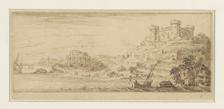

In [6]:
img = Image.open(get_path('inputs/photos/002bff09b09998d0be65.jpg'))
img

In [7]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [8]:
train_cp = train_df.set_index('object_id')
imgs, sorting_dates = [], []

for object_id in tqdm(list(train_cp.index)):
    imgfile = get_path('inputs/photos/{}.jpg'.format(object_id))
    img = Image.open(imgfile).convert('RGB')
    imgs.append(img)
    sorting_dates.append(train_cp.loc[object_id, 'sorting_date'])

100%|██████████| 3937/3937 [14:13<00:00,  4.61it/s]


In [9]:
print('sorting_dates', len(sorting_dates))
print('imgs', len(imgs))

sorting_dates 3937
imgs 3937


In [10]:
img_train, img_valid, target_train, target_valid = train_test_split(imgs, sorting_dates, test_size=0.3, random_state=0)
print(len(img_train), len(img_valid))
print(len(target_train), len(target_valid))

2755 1182
2755 1182


In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data=img_train, target=target_train, mode='train'):
        self.data = data
        self.target = target
        self.mode = mode

        if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(90),
                transforms.Resize(256),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __getitem__(self, idx):
        img = self.data[idx]
        target = self.target[idx]
        transformed_image = self.transform(img)
        target = torch.tensor(target, dtype=torch.float32).unsqueeze(-1)
        return transformed_image, target

    def __len__(self):
        return len(self.data)

In [12]:
train = Dataset(data=img_train, target=target_train, mode='train')
valid = Dataset(data=img_valid, target=target_valid, mode='valid')

In [13]:
pl.seed_everything(0)
batch_size = 256
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size)

Global seed set to 0


In [14]:
# 確認
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256, 1]))

In [15]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64*56*56, 1)

    def forward(self, x):
        h = self.conv1(x) # (bs, 3, 224, 224) -> (bs, 32, 224, 224)
        h = self.bn1(h) # (bs, 32, 224, 224) -> (bs, 32, 224, 224)
        h = F.relu(h) # (bs, 32, 224, 224) -> (bs, 32, 224, 224)
        h = F.max_pool2d(h, kernel_size=2, stride=2) # (bs, 32, 224, 224) -> (bs, 32, 112, 112)

        h = self.conv2(h) # (bs, 32, 112, 112) -> (bs, 64, 112, 112)
        h = self.bn2(h) # (bs, 64, 112, 112) -> (bs, 64, 112, 112)
        h = F.relu(h) # (bs, 64, 112, 112) -> (bs, 64, 112, 112)
        h = F.max_pool2d(h, kernel_size=2, stride=2) # (bs, 64, 112, 112) -> (bs, 64, 56, 56)

        h = h.view(-1, 64*56*56) #  (bs, 64, 56, 56) -> (bs, 64*56*56)
        h = self.fc(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = torch.sqrt(F.mse_loss(y, t))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = torch.sqrt(F.mse_loss(y, t))
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer

### 学習

In [16]:
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=100, gpus=1, deterministic=True, logger=logger)
trainer.fit(net, train_loader, valid_loader)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | conv1 | Conv2d      | 896   
1 | bn1   | BatchNorm2d | 64    
2 | conv2 | Conv2d      | 18.5 K
3 | bn2   | BatchNorm2d | 128   
4 | fc    | Linear      | 200 K 
--------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Global seed set to 0


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


In [17]:
trainer.callback_metrics

{'train_loss': tensor(95.9140, device='cuda:0'),
 'train_loss_epoch': tensor(103.4368, device='cuda:0'),
 'train_loss_step': tensor(95.9140, device='cuda:0'),
 'val_loss': tensor(120.7660, device='cuda:0')}

In [18]:
log = pd.read_csv('logs/my_exp/version_0/metrics.csv')

In [19]:
log

,train_loss_epoch,epoch,step,val_loss,train_loss_step
0,499.557526,0,9,NaN,NaN
1,NaN,0,9,430.497192,NaN
2,168.225433,1,19,NaN,NaN
3,NaN,1,19,562.103455,NaN
4,143.506271,2,29,NaN,NaN
...,...,...,...,...,...
215,100.638794,98,989,NaN,NaN
216,NaN,98,989,97.937920,NaN
217,NaN,99,999,NaN,95.914017
218,103.436806,99,999,NaN,NaN


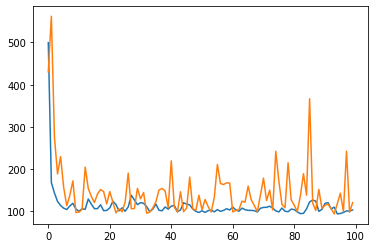

In [20]:
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();